# Multichannel audio source separation by t-ILRMA

In [1]:
%%shell
git clone https://github.com/tky823/audio_source_separation.git
pip install soundfile

Cloning into 'audio_source_separation'...
remote: Enumerating objects: 432, done.
remote: Counting objects: 100% (432/432), done.
remote: Compressing objects: 100% (256/256), done.
remote: Total 1516 (delta 205), reused 343 (delta 138), pack-reused 1084
Receiving objects: 100% (1516/1516), 9.30 MiB | 29.85 MiB/s, done.
Resolving deltas: 100% (689/689), done.


In [2]:
%cd "/content/audio_source_separation/egs/bss-example/ilrma"

/content/audio_source_separation/egs/bss-example/ilrma


## Data preparation
Create multichannel mixtures using the audios of [CMU ARCTIC database](http://www.festvox.org/cmu_arctic/) and impulse responses of [Multi-Channel Impulse Response Database](https://www.iks.rwth-aachen.de/en/research/tools-downloads/databases/multi-channel-impulse-response-database/).

In [3]:
%%shell
. ./prepare.sh

--2021-04-05 07:22:31--  http://festvox.org/cmu_arctic/packed/cmu_us_aew_arctic.tar.bz2
Resolving festvox.org (festvox.org)... 199.4.150.154
Connecting to festvox.org (festvox.org)|199.4.150.154|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93295070 (89M) [application/x-bzip2]
Saving to: ‘data/cmu_us_aew_arctic.tar.bz2’

data/cmu_us_aew_arc 100%[===================>]  88.97M  23.1MB/s    in 7.1s    

2021-04-05 07:22:38 (12.6 MB/s) - ‘data/cmu_us_aew_arctic.tar.bz2’ saved [93295070/93295070]

cmu_us_aew_arctic/wav/
cmu_us_aew_arctic/wav/arctic_a0457.wav
cmu_us_aew_arctic/wav/arctic_a0101.wav
cmu_us_aew_arctic/wav/arctic_a0413.wav
cmu_us_aew_arctic/wav/arctic_a0526.wav
cmu_us_aew_arctic/wav/arctic_b0285.wav
cmu_us_aew_arctic/wav/arctic_a0568.wav
cmu_us_aew_arctic/wav/arctic_a0483.wav
cmu_us_aew_arctic/wav/arctic_a0481.wav
cmu_us_aew_arctic/wav/arctic_b0412.wav
cmu_us_aew_arctic/wav/arctic_a0041.wav
cmu_us_aew_arctic/wav/arctic_a0278.wav
cmu_us_aew_arctic/wav/a

In [4]:
import sys
sys.path.append("../../../src")

In [5]:
import numpy as np
import scipy.signal as ss
import soundfile as sf
import IPython.display as ipd
import matplotlib.pyplot as plt

In [6]:
from bss.ilrma import tILRMA

In [7]:
plt.rcParams['figure.dpi'] = 200

Configuration of STFT
- The reverberation time is $T_{60}=160$ [ms] in the impulse response.
- The window length is $4096$ samples (= $256$ [ms]) because of the assumption of rank-1 constraint.
- The hop length is the half of the window length, i.e. $2048$ samples (= $128$ [ms]) .

In [8]:
fft_size, hop_size = 4096, 2048

## 2 speakers

In [9]:
aew_mic3, sr = sf.read("./data/cmu_us_aew_arctic/trimmed/convolved-16000_deg60-mic3.wav")
axb_mic3, sr = sf.read("./data/cmu_us_axb_arctic/trimmed/convolved-16000_deg300-mic3.wav")
x_mic3 = aew_mic3 + axb_mic3

aew_mic4, sr = sf.read("./data/cmu_us_aew_arctic/trimmed/convolved-16000_deg60-mic4.wav")
axb_mic4, sr = sf.read("./data/cmu_us_axb_arctic/trimmed/convolved-16000_deg300-mic4.wav")
x_mic4 = aew_mic4 + axb_mic4

x = np.vstack([x_mic3, x_mic4])
n_sources, T = x.shape

### Target sources after convolution of impulse response

In [10]:
display(ipd.Audio(aew_mic3, rate=sr))
display(ipd.Audio(axb_mic3, rate=sr))

### Mixture

In [11]:
for idx in range(2):
    display(ipd.Audio(x[idx], rate=sr))

### Execution of ILRMA

In [12]:
_, _, X = ss.stft(x, nperseg=fft_size, noverlap=fft_size-hop_size)

In [13]:
np.random.seed(111)
ilrma = tILRMA(n_bases=2, nu=10**3, normalize='projection-back')

In [14]:
Y = ilrma(X, iteration=50)

In [15]:
_, y = ss.istft(Y, nperseg=fft_size, noverlap=fft_size-hop_size)
y = y[:,:T]

### Separated sources

In [16]:
for idx in range(2):
    display(ipd.Audio(y[idx], rate=sr))

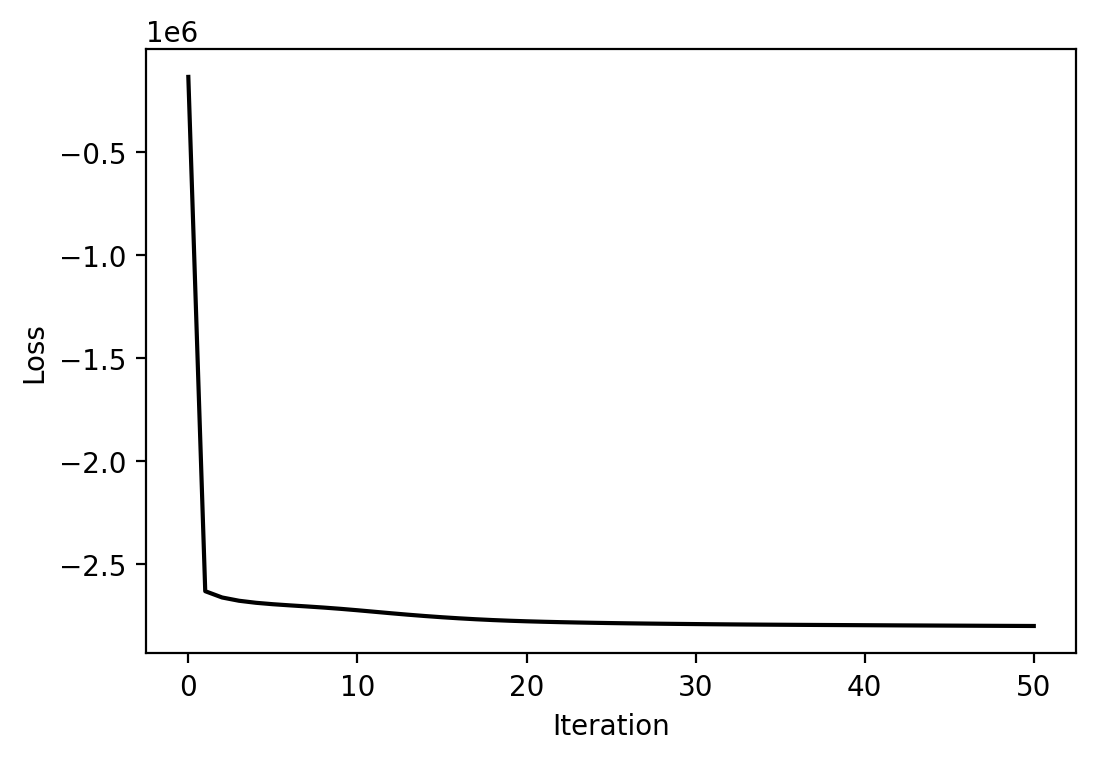

In [17]:
plt.figure()
plt.plot(ilrma.loss, color='black')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

## 3 speakers

In [37]:
aew_mic2, sr = sf.read("./data/cmu_us_aew_arctic/trimmed/convolved-16000_deg60-mic2.wav")
axb_mic2, sr = sf.read("./data/cmu_us_axb_arctic/trimmed/convolved-16000_deg300-mic2.wav")
bdl_mic2, sr = sf.read("./data/cmu_us_bdl_arctic/trimmed/convolved-16000_deg330-mic2.wav")
x_mic2 = aew_mic2 + axb_mic2 + bdl_mic2

aew_mic4, sr = sf.read("./data/cmu_us_aew_arctic/trimmed/convolved-16000_deg60-mic4.wav")
axb_mic4, sr = sf.read("./data/cmu_us_axb_arctic/trimmed/convolved-16000_deg300-mic4.wav")
bdl_mic4, sr = sf.read("./data/cmu_us_bdl_arctic/trimmed/convolved-16000_deg330-mic4.wav")
x_mic4 = aew_mic4 + axb_mic4 + bdl_mic4

aew_mic5, sr = sf.read("./data/cmu_us_aew_arctic/trimmed/convolved-16000_deg60-mic5.wav")
axb_mic5, sr = sf.read("./data/cmu_us_axb_arctic/trimmed/convolved-16000_deg300-mic5.wav")
bdl_mic5, sr = sf.read("./data/cmu_us_bdl_arctic/trimmed/convolved-16000_deg330-mic5.wav")
x_mic5 = aew_mic5 + axb_mic5 + bdl_mic5

x = np.vstack([x_mic2, x_mic4, x_mic5])
n_sources, T = x.shape

### Target sources after convolution of impulse response

In [38]:
display(ipd.Audio(aew_mic2, rate=sr))
display(ipd.Audio(axb_mic2, rate=sr))
display(ipd.Audio(bdl_mic2, rate=sr))

### Mixture

In [39]:
for idx in range(3):
    display(ipd.Audio(x[idx], rate=sr))

### Execution of ILRMA

In [40]:
_, _, X = ss.stft(x, nperseg=fft_size, noverlap=hop_size)

In [46]:
np.random.seed(111)
ilrma = tILRMA(n_bases=2, nu=10**3, normalize='projection-back')

In [47]:
Y = ilrma(X, iteration=100)

In [48]:
_, y = ss.istft(Y, nperseg=fft_size, noverlap=hop_size)
y = y[:,:T]

### Separated sources

In [49]:
for idx in range(3):
    display(ipd.Audio(y[idx], rate=sr))

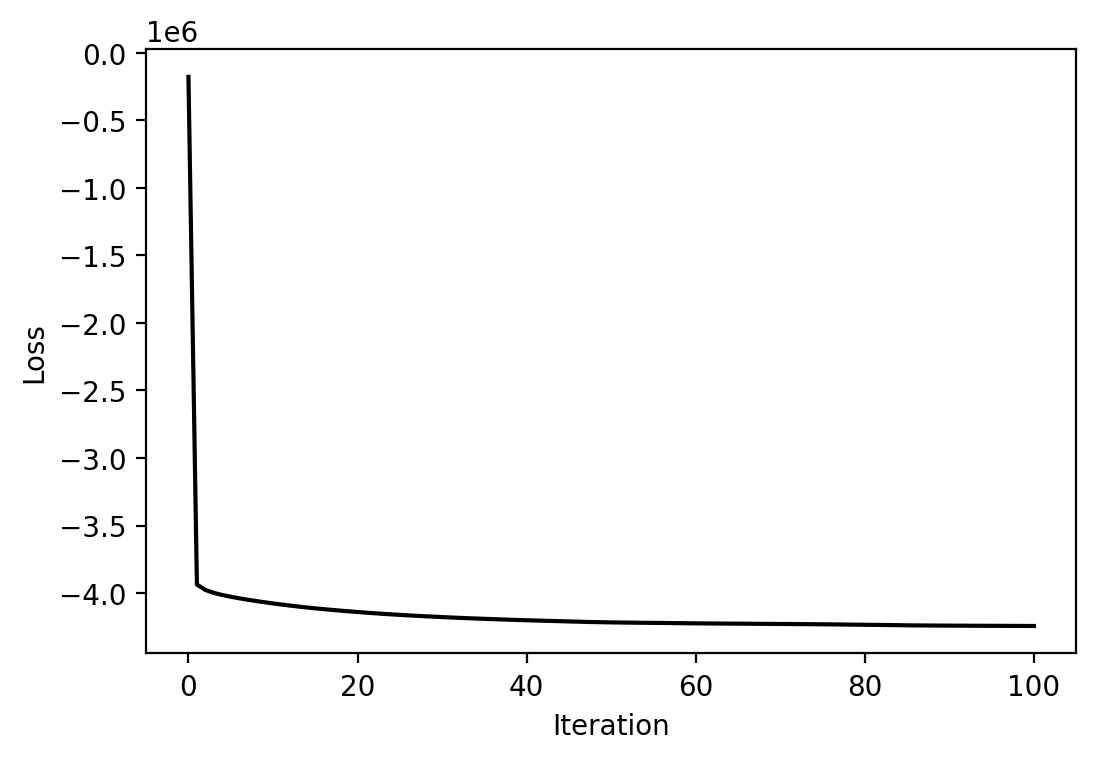

In [45]:
plt.figure()
plt.plot(ilrma.loss, color='black')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

## Comparison between Gauss-ILRMA and t-ILRMA

In [27]:
aew_mic3, sr = sf.read("./data/cmu_us_aew_arctic/trimmed/convolved-16000_deg60-mic3.wav")
axb_mic3, sr = sf.read("./data/cmu_us_axb_arctic/trimmed/convolved-16000_deg300-mic3.wav")
x_mic3 = aew_mic3 + axb_mic3

aew_mic4, sr = sf.read("./data/cmu_us_aew_arctic/trimmed/convolved-16000_deg60-mic4.wav")
axb_mic4, sr = sf.read("./data/cmu_us_axb_arctic/trimmed/convolved-16000_deg300-mic4.wav")
x_mic4 = aew_mic4 + axb_mic4

x = np.vstack([x_mic3, x_mic4])
n_sources, T = x.shape

In [28]:
s = np.vstack([aew_mic3, axb_mic3])
_, _, X = ss.stft(x, nperseg=fft_size, noverlap=fft_size-hop_size)

In [29]:
%%shell
pip install mir_eval

     |████████████████████████████████| 92kB 3.6MB/s 
  Created wheel for mir-eval: filename=mir_eval-0.6-cp37-none-any.whl size=96515 sha256=5175f86180f1e10b295802faeb9ca8c820d07ff73408943c8bff6ffcd041daee
  Stored in directory: /root/.cache/pip/wheels/49/ce/30/730fa72addf275e49d90683b01b3613048b4be3bf7ff8eb6ec
Successfully built mir-eval


In [30]:
from mir_eval.separation import bss_eval_sources

from algorithm.projection_back import projection_back
from bss.ilrma import GaussILRMA

In [31]:
def record_sdri(model):
    reference_id = model.reference_id
    s = model.target # Time domain
    X, Y = model.input, model.estimation # Time-frequency domain
    n_sources, T = s.shape

    scale = projection_back(Y, reference=X[reference_id])
    Y = Y * scale[...,np.newaxis] # (n_sources, n_bins, n_frames)
    _, y = ss.istft(Y, nperseg=fft_size, noverlap=fft_size-hop_size)
    y = y[:,:T]

    if hasattr(model, 'sdr_input'):
        sdr_input = model.sdr_input
    else:
        _, x = ss.istft(X, nperseg=fft_size, noverlap=fft_size-hop_size)
        x = x[reference_id,:T]
        x = np.tile(x, reps=(n_sources, 1))
        sdr_input, _, _, _ = bss_eval_sources(s, estimated_sources=x)
        model.sdr_input = sdr_input

    sdr_estimated, _, _, _ = bss_eval_sources(s, estimated_sources=y)
    sdri = sdr_estimated - sdr_input
    
    model.sdri.append(sdri.mean())

Gives `record_sdri` as a callback function to record SDR improvements.

In [32]:
np.random.seed(111)
gauss_ilrma = GaussILRMA(n_bases=2, normalize='projection-back', callback=record_sdri)
Y = gauss_ilrma(X, iteration=200, target=s, sdri=[])

In [33]:
np.random.seed(111)
t_ilrma2 = tILRMA(n_bases=2, nu=10**2, normalize='projection-back', callback=record_sdri)
Y = t_ilrma2(X, iteration=200, target=s, sdri=[])

In [34]:
np.random.seed(111)
t_ilrma3 = tILRMA(n_bases=2, nu=10**3, normalize='projection-back', callback=record_sdri)
Y = t_ilrma3(X, iteration=200, target=s, sdri=[])

In [35]:
np.random.seed(111)
t_ilrma4 = tILRMA(n_bases=2, nu=10**4, normalize='projection-back', callback=record_sdri)
Y = t_ilrma4(X, iteration=200, target=s, sdri=[])

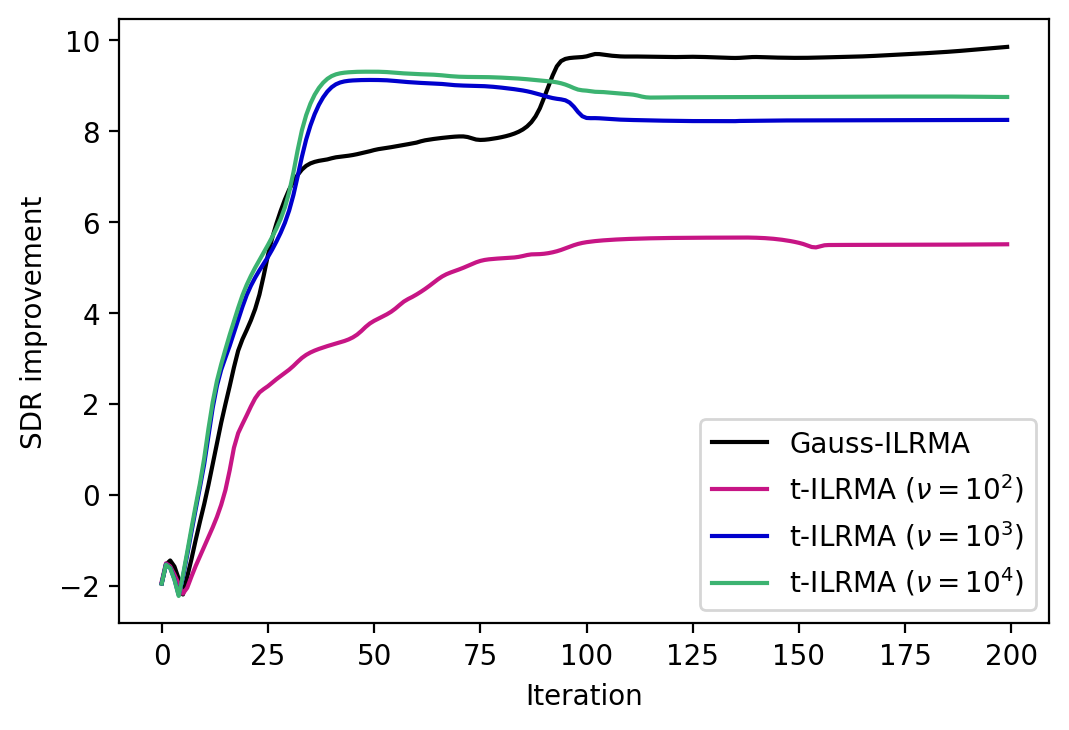

In [36]:
plt.figure()
plt.plot(gauss_ilrma.sdri, color='black', label='Gauss-ILRMA')
plt.plot(t_ilrma2.sdri, color='mediumvioletred', label='t-ILRMA (' + r'$\nu=10^{2}$' + ')')
plt.plot(t_ilrma3.sdri, color='mediumblue', label='t-ILRMA (' + r'$\nu=10^{3}$' + ')')
plt.plot(t_ilrma4.sdri, color='mediumseagreen', label='t-ILRMA (' + r'$\nu=10^{4}$' + ')')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('SDR improvement')
plt.show()